# Team Introduction
Our group is comprised of Braden Anderson, Hien Lam, and Tavin Weeda. 

# Business Understanding
Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific.

Crash Report Sampling System (CRSS) is a probability sample of police-reported traffic crashes used to analyze crash trends and promote highway safety measures as well as public information initiatives. The 2020 data encompassing driver-related, vehicular accidents was obtained. First, we seek to predict injury severity of the crash. This is a classification technique in which effectiveness will be measured with accuracy, recall, F1 score, and ROC AUC in conjunction with 10-fold cross validation. Afterwards, we will conduct regression to predict age of driver and obtain its mean squared error, root mean squared error, and mean absolute percentage error in conjunction with 10-fold cross validation. Our goal is to elucidate factors that contribute to crashes as they relate to the driver, vehicle, road infrastructure, and environment in order to effectively reduce/prevent accidents.

# Data Meaning Type
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from dfply import *
from data_cleaning import *

In [2]:
# df = pd.read_csv('https://raw.githubusercontent.com/lam-hien/MSDS-Projects/main/Crash%20Severity%20Prediction/Data.csv')
df = pd.read_csv("./dataset_revs/Merged_File_05092022.csv")

In [3]:
# Function to clean the data
df = clean_data(dataframe=df)

In [4]:
# Select relevant columns for EDA where values are descriptive (not numerical indicators)
eda_df = df >> select(X.regionname, X.urbanicityname, X.makename, X.body_typname, X.mod_yearname, X.vtrafwayname, 
                      X.vnum_lanname, X.vsurcondname, X.vtrafconname, X.typ_intname, X.wrk_zonename, X.int_hwyname, 
                      X.weathername, X.wkdy_imname, X.hour_imname, X.reljct2_imname, X.lgtcon_imname, X.maxsev_imname, 
                      X.alchl_imname, X.age_im, X.sex_imname, X.vspd_lim, X.trav_sp, X.hour_binned, X.speeding_status)

# Data Quality
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.

Each observation corresponded to a driver from a unique accident, as noted under `casenum` thus duplicate data was a nonissue. Due to the reliance of information contained in police reports, missing values were present with the unreported or unknown designation. The most concerning features were `trav_sp` (traveling vehicle speed) and `vspd_lim` (reported speed limit). We simply plotted the raw values for EDA but will one-hot encode them going forward to keep the full data. The other features had very few unknown/unreported values (less than 1% of the data per variable) and were removed. Most of the outliers encountered were scant distributed among both extremes of categorical levels. We dealt with this by binning similar levels together to ensure the integrity of the data or removed them if they were not representative of our population. For example, age of cars 50+ were binned together and drivers below 16 years of age were removed.

In [5]:
# There are zero na values because the data will designate "unknown" or "unreported" instead.
na_vals = eda_df.isnull().sum()
na_vals[na_vals > 0]

Series([], dtype: int64)

In [6]:
# Verify that there are not any duplicate case numbers in the dataset.
df['casenum'].duplicated().sum()

0

In [7]:
# Check the number of complete observations that are duplicated
df.duplicated().sum()

0

In [8]:
def annotate_extreme_values(ax, feature_name, annot_values, arrow_size=0.2):
    
    feature_name = feature_name.split("_")[0]
    y_lower, y_upper = ax.get_ylim()
    y_range = y_upper - y_lower
    y_center = y_lower + y_range/2
    
    for index, value in enumerate(annot_values, start=1):
        
        if index % 2 == 0:
            arrow_base_start = arrow_size*-1
            arrow_dy = 0.95*arrow_size
            style = dict(size=14, color = "#000000", ha = 'center', va="bottom")
            arrow_size += 0.07
        else:
            arrow_base_start = arrow_size
            arrow_dy = -1*0.95*arrow_size
            style = dict(size=14, color = "#000000", ha = 'center', va="top")
            
        ax.arrow(x=value, 
                 y=arrow_base_start, 
                 dx=0, 
                 dy=arrow_dy, 
                 head_width=1, 
                 head_length=0.03, 
                 length_includes_head=True, 
                 color="#000000")
        
        ax.text(x=value, y=y_center+arrow_base_start, s=f"{feature_name}={value}", **style)
        
    return ax

def create_boxenplot(dataframe, feature, figsize, title=None, title_fontsize=24, title_weight='bold', xlab_fontsize=16, 
                     seaborn_style='white', xtick_fontsize=20, annot_vshift=-0.01, k_depth='tukey', outlier_prop=0.007, num_min_annot=3, 
                     num_max_annot=2, plot_percentiles=[25, 50, 75], percentile_colors=["#FF69B4", "#FFFF00","#39FF14"], annot_outliers=True,
                     annot_percentiles=True, annot_mean=True):
    
    sns.set_style(seaborn_style)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, squeeze=True)
    
    sns.boxenplot(x=feature, data=dataframe, outlier_prop=outlier_prop, k_depth=k_depth, ax=ax)
    
    ax.set_title(title, fontsize=title_fontsize, weight=title_weight)
    ax.set_xlabel(f"Distribution of {feature}", fontsize=xlab_fontsize)
    ax.tick_params(axis='both', labelsize=xtick_fontsize)
    
    sorted_ages = dataframe[feature].sort_values().to_numpy()
    min_values = sorted_ages[:num_min_annot]
    max_values = sorted_ages[-num_max_annot:]
    
    if annot_outliers:
        ax = annotate_extreme_values(ax=ax, annot_values=min_values, feature_name=feature)
        ax = annotate_extreme_values(ax=ax, annot_values=max_values, feature_name=feature)
    
    percentiles = dataframe[feature].quantile(q=np.array(plot_percentiles)/100).to_numpy()
    
    y_lower, y_upper = ax.get_ylim()
    y_range = y_upper - y_lower
    y_center = y_lower + y_range/2
    
    if annot_percentiles:
        for percentile_value, percentile, color in zip(percentiles, plot_percentiles, percentile_colors):
            ax.vlines(x=percentile_value, ymin=y_center+y_upper*0.12, ymax=y_center+y_upper*0.93, linewidth=3, colors=color)
            style = dict(size=12, color = color, ha = 'center', va="center", weight='bold')
            ax.text(x=percentile_value, y=y_center, s=f"{percentile}th\npercentile={percentile_value}", **style)
            ax.vlines(x=percentile_value, ymin=y_center+y_lower*0.93, ymax=y_center+y_lower*0.12, linewidth=3, colors=color)
        
    if annot_mean:
        mean = dataframe[feature].mean()
        ax.vlines(x=mean, ymin=y_center+y_lower*0.95, ymax=y_center+y_upper*0.95, linewidth=2, linestyle='dashed',colors="#000000")
        style = dict(size=14, color = "#000000", ha = 'center', va="center", weight='bold')
        ax.text(x=mean, y=y_upper*0.96, s=f"mean={round(mean,3)}", **style)

    return ax

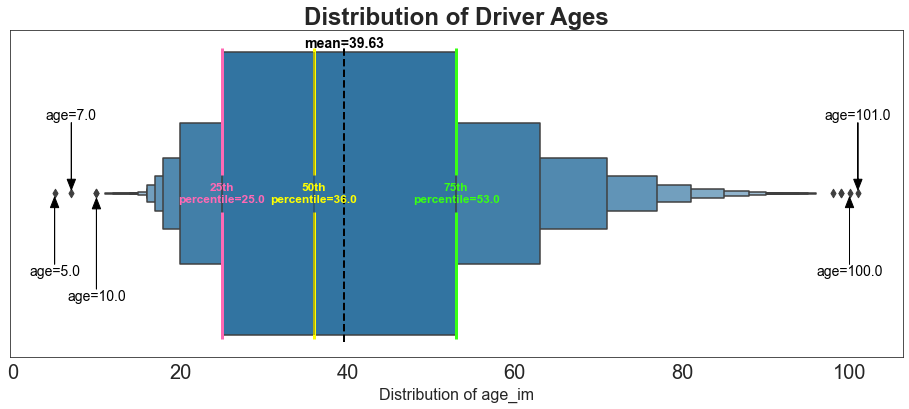

In [9]:
ax = create_boxenplot(dataframe=df, feature='age_im', figsize=(16, 6), title="Distribution of Driver Ages")

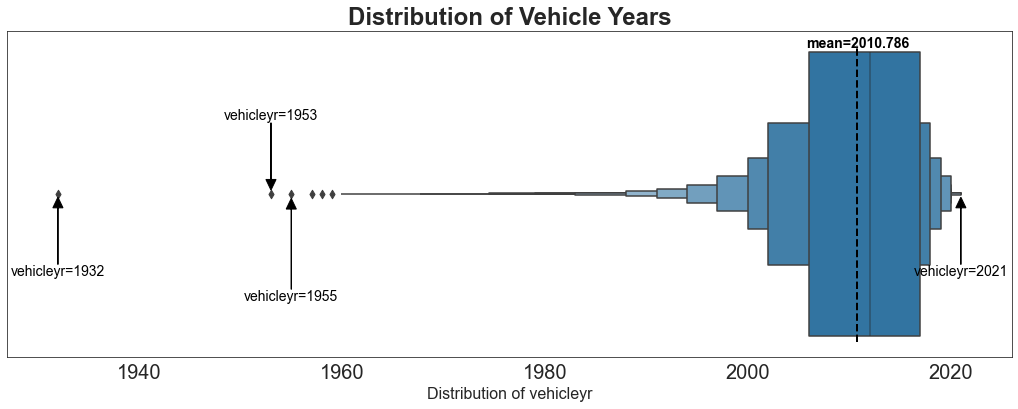

In [10]:
known_years_df = df.loc[~df['mod_yearname'].isin(['Unknown','Not Reported']),:].copy(deep=True)
known_years_df['vehicleyr'] = known_years_df['mod_yearname'].astype(int)
ax = create_boxenplot(dataframe=known_years_df, 
                      feature='vehicleyr', 
                      figsize=(18, 6), 
                      title="Distribution of Vehicle Years", 
                      annot_outliers=True, 
                      annot_percentiles=False, 
                      annot_mean=True, 
                      num_max_annot=1)